In [1]:
import pandas as pd
import numpy as np
import pickle
import gc
import os
import time
import copy
import multiprocessing as mp
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer
from tqdm import tqdm
from scipy import sparse, spatial
import warnings
warnings.filterwarnings('ignore')
tqdm.pandas()

In [2]:
tic = time.time()
DATA_PATH = '../pkl/'
SAVE_PATH = './feats/'
if not os.path.exists(SAVE_PATH):
    print('create dir: %s' % SAVE_PATH)
    os.mkdir(SAVE_PATH)

print('gen_local_user_ques_expo...')

gen_local_user_ques_expo...


In [3]:
invite_info = pd.read_pickle(os.path.join(DATA_PATH, 'invite_info.pkl'))
invite_info_evaluate = pd.read_pickle(os.path.join(DATA_PATH, 'invite_info_evaluate.pkl'))
data = pd.read_pickle(os.path.join(DATA_PATH, 'invite_data.pkl'))

In [4]:
oversample = True

In [5]:
if oversample:
    data_s = pd.concat([invite_info, invite_info_evaluate, invite_info_evaluate])
else:
    data_s = pd.concat([invite_info, invite_info_evaluate])

In [6]:
print(len(data), len(data_s))

10630845 11772528


In [7]:
# 问题曝光
tmp = data_s[['qid', 'itime']].groupby(['qid', 'itime']).size().reset_index()
tmp.columns = ['qid', 'itime', 'expo']
tmp = tmp.sort_values(by=['qid','itime'])
tmp['question_history_expo'] = tmp.groupby('qid')['expo'].cumsum() - tmp['expo']
tmp = tmp.sort_values(by=['qid','itime'], ascending=False)
tmp['question_future_expo'] = tmp.groupby('qid')['expo'].cumsum() - tmp['expo']
tmp['question_time'] = tmp['qid'].astype(str) + '_' + tmp['itime'].astype(str)
tmp.rename(columns={'expo': 'question_curr_expo'}, inplace=True)
data['question_time'] = data['qid'].astype(str) + '_' + data['itime'].astype(str)
data = data.merge(tmp[['question_time', 'question_curr_expo', 'question_history_expo', 'question_future_expo']], 'left', 'question_time')
print(len(data))    

10630845


In [8]:
# 用户曝光
tmp = data_s[['uid', 'itime']].groupby(['uid', 'itime']).size().reset_index()
tmp.columns = ['uid', 'itime', 'expo']
tmp = tmp.sort_values(by=['uid','itime'])
tmp['user_history_expo'] = tmp.groupby('uid')['expo'].cumsum() - tmp['expo']
tmp = tmp.sort_values(by=['uid','itime'], ascending=False)
tmp['user_future_expo'] = tmp.groupby('uid')['expo'].cumsum() - tmp['expo']
tmp.rename(columns={'expo': 'user_curr_expo'}, inplace=True)
tmp['user_time'] = tmp['uid'].astype(str) + '_' + tmp['itime'].astype(str)
data['user_time'] = data['uid'].astype(str) + '_' + data['itime'].astype(str)
data = data.merge(tmp[['user_time', 'user_curr_expo', 'user_history_expo', 'user_future_expo']], 'left', 'user_time')
print(len(data))

10630845


In [9]:
data[['question_curr_expo', 'question_history_expo', 'question_future_expo', 
      'user_curr_expo', 'user_history_expo', 'user_future_expo']].to_pickle(os.path.join(SAVE_PATH, 'local_user_ques_expo.pkl'))

In [10]:
toc = time.time()
print('Used time: %d' % int(toc-tic))

Used time: 119


In [11]:
data.head()

,iday,ihour,itime,label,qid,uid,question_time,question_curr_expo,question_history_expo,question_future_expo,user_time,user_curr_expo,user_history_expo,user_future_expo
0,3865,22,92782,0.0,2166419046,401693808,2166419046_92782,14,28,1,401693808_92782,1,2,3
1,3844,11,92267,0.0,1550017551,3392373099,1550017551_92267,1,4,10,3392373099_92267,2,2,4
2,3862,15,92703,0.0,604029601,2317670257,604029601_92703,1,2,3,2317670257_92703,1,11,3
3,3849,11,92387,0.0,2350061229,1618461867,2350061229_92387,2,5,1,1618461867_92387,1,1,5
4,3867,4,92812,0.0,2443223942,3544409350,2443223942_92812,1,236,119,3544409350_92812,2,7,2


In [12]:
import seaborn as sns

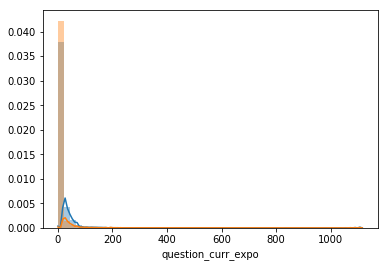

In [13]:
sns.distplot(data[data['label'] == 0]['question_curr_expo'])
sns.distplot(data[data['label'] == 1]['question_curr_expo'])

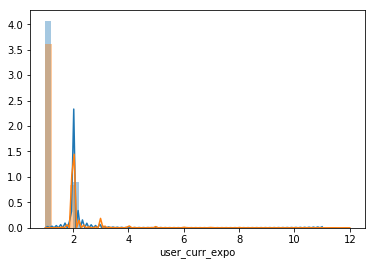

In [14]:
sns.distplot(data[data['label'] == 0]['user_curr_expo'])
sns.distplot(data[data['label'] == 1]['user_curr_expo'])

In [15]:
len(invite_info)

9489162

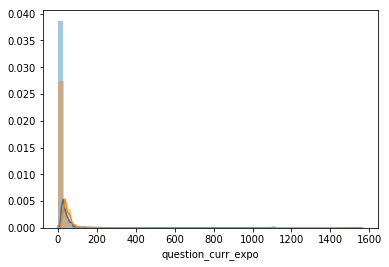

In [16]:
sns.distplot(data[:9489162]['question_curr_expo'])
sns.distplot(data[9489162:]['question_curr_expo'])

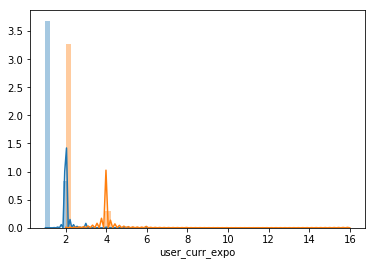

In [17]:
sns.distplot(data[:9489162]['user_curr_expo'])
sns.distplot(data[9489162:]['user_curr_expo'])